In [4]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
sites = [
	{"id": "1-800-flowers", "count" : 15,"label" : 0},
	{"id": "Alfred Sung", "count" : 15,"label" : 0},
	{"id": "Alibaba", "count" : 15,"label" : 1},
	{"id": "Amazon", "count" : 18,"label" : 1},
	{"id": "American Apparel", "count" : 15,"label" : 0},
	{"id": "Arngren", "count" : 15,"label" : 0},
	{"id": "Azteca Soccer", "count" : 15,"label" : 1},
	{"id": "Best Electronic", "count" : 17,"label" : 0},
	{"id": "BestBuy", "count" : 18,"label" : 1},
	{"id": "BigCommerce", "count" : 18,"label" : 1},
	{"id": "Blinkee", "count" : 16,"label" : 0},
	{"id": "Bliss", "count" : 15,"label" : 1},
	{"id": "BonBonBon", "count" : 19,"label" : 1},
	{"id": "Costco", "count" : 15,"label" : 0},
	{"id": "CruiseMaster", "count" : 15,"label" : 1},
	{"id": "Custom Barres", "count" : 15,"label" : 1},
	{"id": "CVS", "count" : 15,"label" : 0},
	{"id": "Decibullz", "count" : 15,"label" : 1},
	{"id": "DSW", "count" : 16,"label" : 0},
	{"id": "eBay", "count" : 16,"label" : 1},
	{"id": "Electrifying Times", "count" : 15,"label" : 0},
	{"id": "Fanatics", "count" : 15,"label" : 0},
	{"id": "Flipkart", "count" : 15,"label" : 1},
	{"id": "Footlocker", "count" : 15,"label" : 0},
	{"id": "Free City Supershop", "count" : 11,"label" : 0},
	{"id": "H & M", "count" : 19,"label" : 0},
	{"id": "Home Science Tools", "count" : 15,"label" : 1},
	{"id": "Ikea", "count" : 16,"label" : 0},
	{"id": "Jabong", "count" : 15,"label" : 1},
	{"id": "Jeep People", "count" : 15,"label" : 1},
	{"id": "Koi Computer", "count" : 15,"label" : 1},
	{"id": "Lazada", "count" : 16,"label" : 1},
	{"id": "Ling's Cars", "count" : 15,"label" : 0},
	{"id": "Mednat", "count" : 15,"label" : 0},
	{"id": "Mercia Tourist Board", "count" : 12,"label" : 0},
	{"id": "Microcenter.com", "count" : 18, "label" : 0},
	{"id": "Next Chapter", "count" : 15,"label" : 1},
	{"id": "Nordstrom", "count" : 16,"label" : 0},
	{"id": "Opensky", "count" : 15,"label" : 0},
	{"id": "P & M Computers", "count" : 15,"label" : 0},
	{"id": "Paradise With A View", "count" : 15,"label" : 0},
	{"id": "Pennyjuice", "count" : 12,"label" : 0},
	{"id": "Rakuten", "count" : 19,"label" : 0},
	{"id": "RalphLauren.com", "count" : 19,"label" : 0},
	{"id": "Renogy", "count" : 16,"label" : 1},
	{"id": "Rusty Surfboards", "count" : 15,"label" : 1},
	{"id": "Shopee", "count" : 16,"label" : 1},
	{"id": "Shopify", "count" : 15,"label" : 1},
	{"id": "Signal Boosters", "count" : 15,"label" : 1},
	{"id": "Skullcandy", "count" : 16,"label" : 1},
	{"id": "SnapDeal", "count" : 15,"label" : 1},
	{"id": "Suzanne Collins Books", "count" : 15,"label" : 0},
	{"id": "The Mountain", "count" : 18,"label" : 1},
	{"id": "True Links Wear", "count" : 16,"label" : 1},
	{"id": "Urban Outfitters", "count" : 15,"label" : 0},
	{"id": "Walgreens", "count" : 16,"label" : 0},
	{"id": "Walmart", "count" : 15,"label" : 1},
	{"id": "Water Equipment", "count" : 18,"label" : 0},
	{"id": "Woocommerce", "count" : 15,"label" : 1},
	{"id": "Zalora", "count" : 16,"label" : 1}   
]

In [ ]:
folds = [[] for i in range(5)]
good = [x for x in sites if x["label"] == 1]
bad = [x for x in sites if x["label"] == 0]
shuffle(good)
shuffle(bad)
for i in range(30):
    folds[i//6].append(good[i])
    folds[i//6].append(bad[i])

for i in range(5):
    print("Fold",i);
    for j in folds[i]:
        print(j["id"],j["count"],j["label"])
    print()

In [ ]:
# data = [[] for i in range(5)]
# labels = [[] for i in range(5)]
# sum = 0
# for i in range(0,5):
#     for site in folds[i]:
#         sum += site["count"]
#         for j in range(1,site['count'] + 1):
# #         for i in range(1,2):
#             labels[i] = labels[i] + [site["label"]]
#             temp = PIL.Image.open("%s/%s - %02d.png" % (site['id'],site['id'],j))
#             temp = np.array(temp);
#             temp = resize(temp, (temp.shape[0] // 2, temp.shape[1] // 2), anti_aliasing=True)
#             data[i].append(temp)
#             print("Loading %s/%s - %02d.png" % (site['id'],site['id'],j))
# print("Loaded %d screens." % sum)
# print(labels)

In [1]:
import pickle

In [ ]:
# with open('data.pt', 'wb') as f:
#     pickle.dump(data, f)
    
# with open('labels.pt', 'wb') as f:
#     pickle.dump(labels, f)

In [2]:
with open('data.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labels.pt', 'rb') as f:
    labels = pickle.load(f)

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_dim, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(786816, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 2)
    
    def forward(self, X):
        out = X.view(X.size(0), -1)
        out = self.dropout(torch.relu(self.fc1(out)))
        out = self.dropout(torch.relu(self.fc2(out)))
        out = self.dropout(torch.relu(self.fc3(out)))
        out = torch.log_softmax(self.fc4(out), 1)
        return out

In [ ]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        d = []
        l = []
        for i in range(5):
            if i != testI:
                d = d + data[i];
                l = l + labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [ ]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

In [ ]:
def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

In [ ]:
def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

In [ ]:
def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

In [ ]:
avedloss, avedacc, avevloss, avevacc = 0,0,0,0
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

batch_size = 32
disable = True
epochs = 100

for i in range(5):
    model = MLP(hidden_dim=256, dropout=0.5).cuda()
    optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.1)
    #amp_handle.wrap_optimizer(optimizer)
    criterion = nn.CrossEntropyLoss()
    #amp_handle = amp.init()
    dlosscurve = []
    dacccurve = []
    vlosscurve = []
    vacccurve = []
    print("Fold %d" % (i + 1))
    my_data.setTest(i)
    my_test.setTest(i)
    
    my_loader = DataLoader(my_data, batch_size=batch_size,
                            shuffle=True)
    my_test_loader = DataLoader(my_test, batch_size=batch_size,
                            shuffle=True)
    for j in range(epochs):
        dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
        vloss, vacc = test(model,criterion,my_test_loader,disable)
        dlosscurve.append(dloss)
        dacccurve.append(dacc)
        vlosscurve.append(vloss)
        vacccurve.append(vacc)
        if j % 10 == 0:
            print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
    df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
    df.plot.line()
    avedloss += dloss
    avedacc += dacc
    avevloss += vloss
    avevacc += vacc
avedloss /= 5
avedacc /= 5
avevloss /= 5
avevacc /= 5
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))

In [ ]:
class AutoUXFullDataset(Dataset):
    def __init__(self, data, labels):
        super(AutoUXFullDataset,self).__init__()
        self.data = data
        self.labels = labels
        d = []
        l = []
        for i in range(5):
            d = d + data[i];
            l = l + labels[i]
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')

    def __len__(self):
        return len(self.trainX)
    
    def __getitem__(self, idx):
        return {"img" : self.trainX[idx], "label": self.trainY[idx]}

In [ ]:
avedloss, avedacc = 0,0
my_data = AutoUXFullDataset(data,labels)

batch_size = 64
disable = False
epochs = 50
every_other = 1

model = MLP(256,0.5).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
#amp_handle.wrap_optimizer(optimizer)
criterion = nn.CrossEntropyLoss()
#amp_handle = amp.init()
dlosscurve = []
dacccurve = []

my_loader = DataLoader(my_data, batch_size=batch_size,
                        shuffle=True)
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}".format(dloss,dacc * 100))
df = pd.DataFrame(data={"train_loss": dlosscurve})
df.plot.line()
avedloss += dloss
avedacc += dacc
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}".format(avedloss,avedacc))

In [ ]:
my_loader = DataLoader(my_data, batch_size=batch_size,
                        shuffle=False)
answers = np.array([])
with torch.no_grad():
    for s in tqdm(my_loader,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
answers = np.exp(answers)
print(answers)

In [ ]:
with open('mlpoutprob.pt', 'wb') as f:
    pickle.dump(answers, f)

Confusion matrix, without normalization
[[464   1]
 [356 117]]
Normalized confusion matrix
[[1.   0.  ]
 [0.75 0.25]]


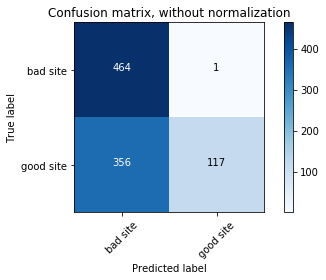

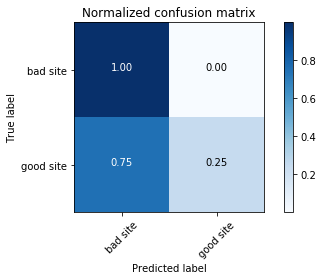

Accuracy: 0.6194


In [6]:
from sklearn.metrics import *
import itertools
import pickle
with open('mlpout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))
